In [0]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

from tqdm import tqdm
import sys, random, glob
from itertools import chain
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from inception_score import get_inception_score
from fid import get_fid_score

In [0]:
SEED = 1234
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
# batches of 64 images of size 32x32x3

BATCH_SIZE = 64
NUM_WORKERS = 4
LATENT_DIM = 100
IN_CHANNELS = 3
OUT_CHANNELS = 3

IMG_SIZE = 32

transform = transforms.Compose([transforms.Resize(IMG_SIZE),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.CIFAR10('datasets/CIFAR10',
                               transform=transform)

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=NUM_WORKERS)

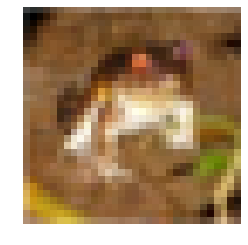

In [0]:
img, _ = dataset[0] # image data should either be floats in [0, 1] or integers in [0, 255]
assert img.shape == (IN_CHANNELS, IMG_SIZE, IMG_SIZE)
assert isinstance(img, torch.Tensor)

img = (img.permute(1, 2, 0) + 1)/2 # HWC and denorm

ax = plt.gca()
ax.imshow(img)
ax.axis('off')
plt.show()

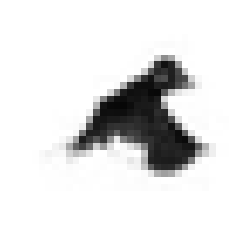

In [0]:
imgs, _ = next(iter(dataloader))

assert imgs.shape == (BATCH_SIZE, IN_CHANNELS, IMG_SIZE, IMG_SIZE)
assert isinstance(imgs, torch.Tensor)

img = (imgs[0].permute(1, 2, 0) + 1)/2 # HWC and denorm

ax = plt.gca()
ax.imshow(img)
ax.axis('off')
plt.show()

In [0]:
# W --> (W - 1)S + K - 2P
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_ch):
        super().__init__()

        self.model = nn.Sequential(
            # input is z: 100 x (1 x 1)
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # state size: 512 x (4 x 4)
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # state size: 256 x (8 x 8)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # state size: 128 x (16 x 16)
            nn.ConvTranspose2d(128, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # state size: 64 x (16 x 16)
            nn.ConvTranspose2d(64, output_ch, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: och x (32 x 32)
        )
        # input order: NCHW (batch, channels, height, width)
        
    def forward(self, z):
        Gz = self.model(z)
        return Gz

In [0]:
# W --> [(W - K + 2P)/S + 1]
class Encoder(nn.Module):
    def __init__(self, input_ch, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            # input size: ich x (32 x 32)
            nn.Conv2d(input_ch, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: 64 x (16 x 16)
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: 128 x (16 x 16)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: 256 x (8 x 8)
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: 512 x (4 x 4)
            nn.Conv2d(512, latent_dim, 4, 1, 0, bias=False), # changed (512, 1, ..) to (512, 100, ..), removed sigmoid, removed flattening from forward
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [0]:
# custom weights initialization for G, D
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

        
netAE = nn.Sequential(Encoder(IN_CHANNELS, LATENT_DIM),
                      Decoder(LATENT_DIM, OUT_CHANNELS)).to(device)
netAE.apply(init_weights)
netAE

Sequential(
  (0): Encoder(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace)
      (11): Conv2d(512, 100, kernel_size=(4, 4), stride=(1, 1), bias=False)
    )
  )
  (1): Decoder(
    (mod

In [0]:
opt = optim.Adam(netAE.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = torch.nn.MSELoss()

def denorm(x):
    out = (x + 1)/2
    return out.clamp(0, 1)

In [0]:
SAMPLES = 6
imgloader = torch.utils.data.DataLoader(dataset, batch_size=SAMPLES, shuffle=True)
imgs, _ = next(iter(imgloader))
imgs = imgs.to(device)

In [0]:
#=========================AUTOENCODER=========================#
EPOCHS = 30
SAVE_EVERY = 2
losses = []

for e in range(1, EPOCHS + 1):
    losses.append(0)
    
    #--------------------Training--------------------#
    for x, _ in dataloader:
        x = x.to(device)
        
        fx = netAE(x)
        loss = criterion(fx, x); losses[-1] += loss.item()
        opt.zero_grad()    
        loss.backward()
        opt.step()
    
    #---------------------Logging---------------------#
    losses[-1] /= len(dataloader)
    
    print(f"Epoch: {e:02}/{EPOCHS} "
          f"| Loss: {losses[-1]:.5f}", file=sys.stderr)
    
    #-------------------Save & Plot-------------------#
    if e % SAVE_EVERY == 0:
        filepath = f'models/notebook23/netAE-{e:02}-{losses[-1]:.4f}.pt'
        torch.save(netAE.state_dict(), filepath)
        
        with torch.no_grad():
            gen_imgs = netAE(imgs)

        fig, ax = plt.subplots(figsize=(22, 20), nrows=1, ncols=2*SAMPLES)
        for i in range(2*SAMPLES):
            img = gen_imgs[(i - 1) // 2] if i%2 else imgs[i // 2]
            img = denorm(img.data.cpu().permute(1, 2, 0))
            ax[i].imshow(img)
            ax[i].axis('off')
        plt.show()

# training time: 1.2 min/epoch, 36 mins

In [0]:
ls = glob.glob('models/notebook23/netAE-30-*')
filename = ls[-1]; print(filename)

netAE.load_state_dict(torch.load(filename, map_location=device))

next(netAE.parameters()).device

models/notebook23/netAE-30-0.0180.pt


device(type='cuda', index=0)

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

    
layersG = list(netAE[1].model.children())
layersD = list(netAE[0].model.children())

netG = nn.Sequential(*layersG).to(device)
netD = nn.Sequential(*layersD[:-1],
                    nn.Conv2d(512, 1, 4, 1, 0, bias=False),
#                     nn.Sigmoid(), # not needed for LSGAN
                    Flatten()).to(device)

In [0]:
netG # len(netG), netG[0] also work

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace)
  (9): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [0]:
netD

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace)
  (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Flatten()
)

In [0]:
for i, layer in enumerate(netG.children()):
    if i in (0, 3): # changed (0, 1) to (0, 3)
        continue
    else:
        layer.apply(init_weights)

for i, layer in enumerate(netD.children()):
    if i in (8,): # changed (8, 9) to (8,)
        continue
    else:
        layer.apply(init_weights)
        

In [0]:
optG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

Epoch: 01/65 | Gen. Loss: 0.78044 | Disc. Loss: 0.23616 | Incep. Score: 1.89228


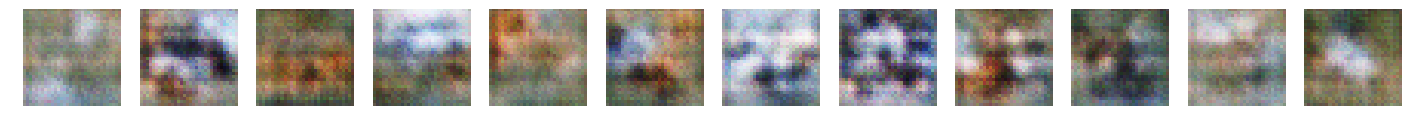

Epoch: 02/65 | Gen. Loss: 0.46602 | Disc. Loss: 0.16710 | Incep. Score: 2.14575


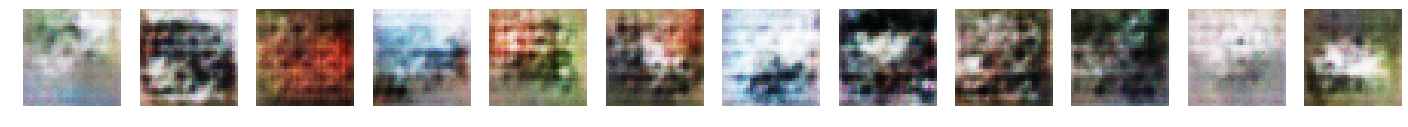

Epoch: 03/65 | Gen. Loss: 0.45274 | Disc. Loss: 0.17869 | Incep. Score: 2.95314


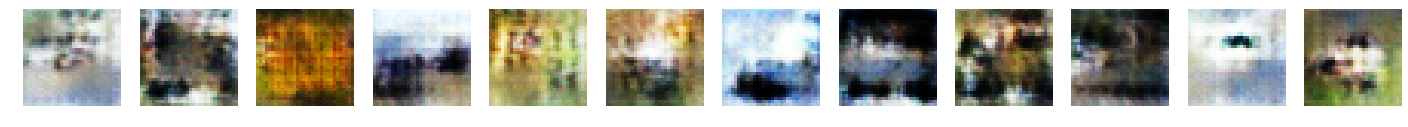

Epoch: 04/65 | Gen. Loss: 0.46458 | Disc. Loss: 0.15756 | Incep. Score: 3.79568


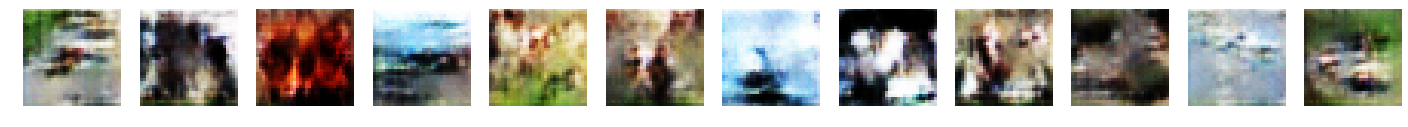

Epoch: 05/65 | Gen. Loss: 0.41799 | Disc. Loss: 0.18030 | Incep. Score: 3.90998


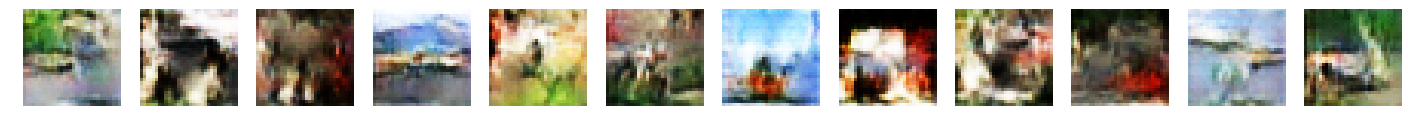

Epoch: 06/65 | Gen. Loss: 0.38616 | Disc. Loss: 0.18952 | Incep. Score: 4.32679


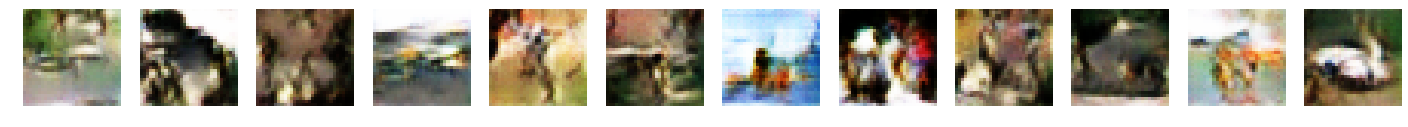

Epoch: 07/65 | Gen. Loss: 0.39813 | Disc. Loss: 0.17838 | Incep. Score: 4.46359


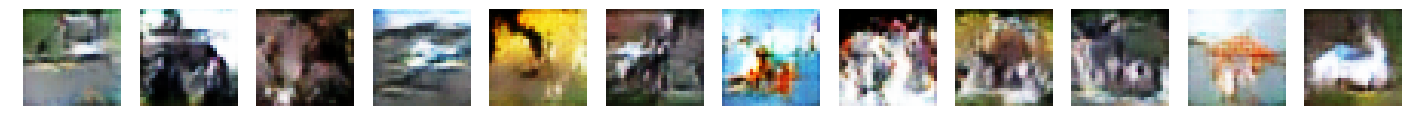

Epoch: 08/65 | Gen. Loss: 0.38957 | Disc. Loss: 0.18448 | Incep. Score: 4.48036


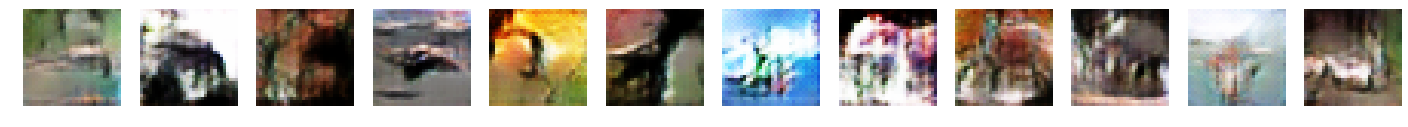

Epoch: 09/65 | Gen. Loss: 0.37070 | Disc. Loss: 0.18913 | Incep. Score: 5.05462


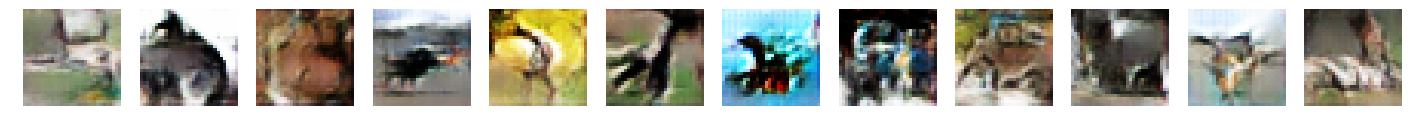

Epoch: 10/65 | Gen. Loss: 0.35520 | Disc. Loss: 0.19662 | Incep. Score: 5.25082


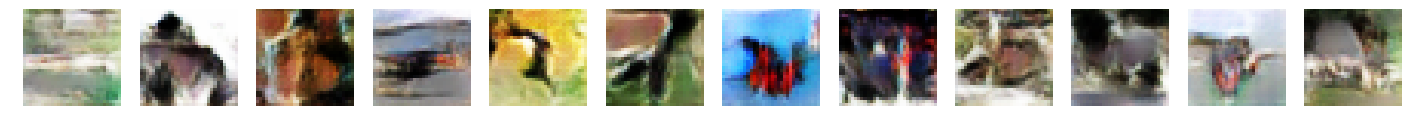

Epoch: 11/65 | Gen. Loss: 0.34438 | Disc. Loss: 0.20194 | Incep. Score: 5.49489


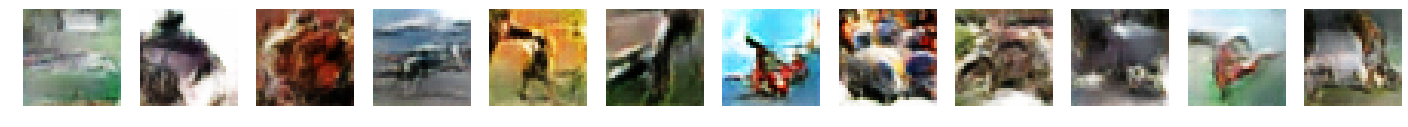

Epoch: 12/65 | Gen. Loss: 0.33796 | Disc. Loss: 0.20123 | Incep. Score: 5.22746
Epoch: 13/65 | Gen. Loss: 0.33051 | Disc. Loss: 0.20719 | Incep. Score: 5.73712


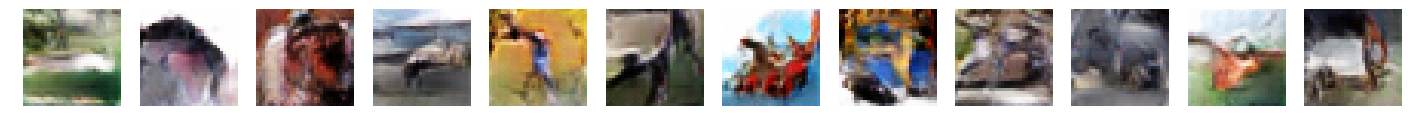

Epoch: 14/65 | Gen. Loss: 0.32341 | Disc. Loss: 0.21016 | Incep. Score: 5.83082


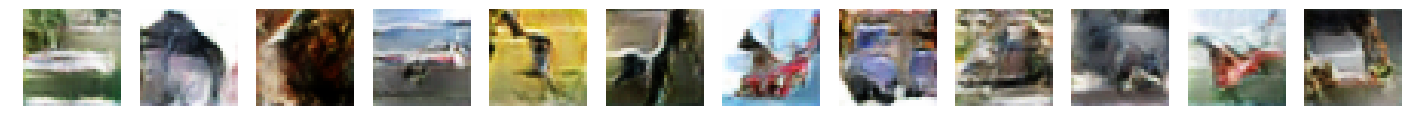

Epoch: 15/65 | Gen. Loss: 0.33847 | Disc. Loss: 0.19316 | Incep. Score: 6.11305


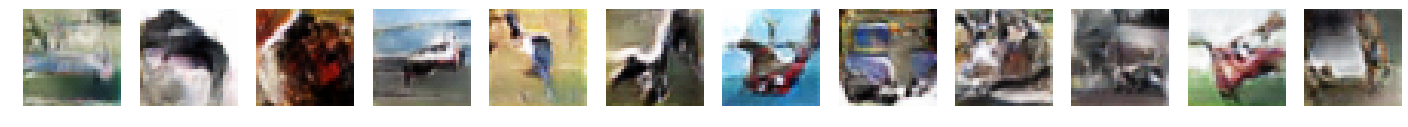

Epoch: 16/65 | Gen. Loss: 0.34769 | Disc. Loss: 0.19394 | Incep. Score: 6.33193


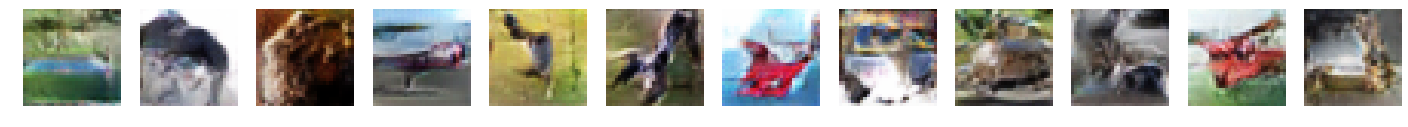

Epoch: 17/65 | Gen. Loss: 0.33834 | Disc. Loss: 0.19672 | Incep. Score: 5.98600
Epoch: 18/65 | Gen. Loss: 0.35772 | Disc. Loss: 0.18768 | Incep. Score: 6.39937


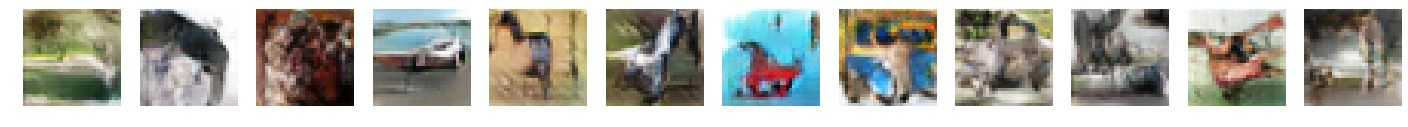

Epoch: 19/65 | Gen. Loss: 0.34822 | Disc. Loss: 0.18082 | Incep. Score: 6.13121
Epoch: 20/65 | Gen. Loss: 0.36575 | Disc. Loss: 0.17640 | Incep. Score: 5.98737
Epoch: 21/65 | Gen. Loss: 0.37283 | Disc. Loss: 0.16706 | Incep. Score: 6.11354
Epoch: 22/65 | Gen. Loss: 0.38022 | Disc. Loss: 0.16843 | Incep. Score: 6.03233
Epoch: 23/65 | Gen. Loss: 0.37320 | Disc. Loss: 0.16217 | Incep. Score: 5.90369
Epoch: 24/65 | Gen. Loss: 0.34326 | Disc. Loss: 0.18490 | Incep. Score: 6.22382
Epoch: 25/65 | Gen. Loss: 0.39433 | Disc. Loss: 0.15187 | Incep. Score: 6.20294
Epoch: 26/65 | Gen. Loss: 0.39835 | Disc. Loss: 0.15247 | Incep. Score: 6.31409
Epoch: 27/65 | Gen. Loss: 0.38925 | Disc. Loss: 0.15593 | Incep. Score: 6.24770
Epoch: 28/65 | Gen. Loss: 0.40692 | Disc. Loss: 0.14131 | Incep. Score: 6.49030


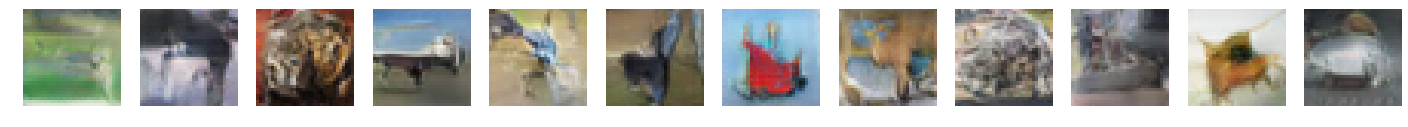

Epoch: 29/65 | Gen. Loss: 0.41437 | Disc. Loss: 0.13816 | Incep. Score: 6.47519
Epoch: 30/65 | Gen. Loss: 0.42071 | Disc. Loss: 0.13091 | Incep. Score: 6.31686
Epoch: 31/65 | Gen. Loss: 0.42822 | Disc. Loss: 0.12900 | Incep. Score: 6.42019
Epoch: 32/65 | Gen. Loss: 0.42875 | Disc. Loss: 0.13277 | Incep. Score: 6.50492


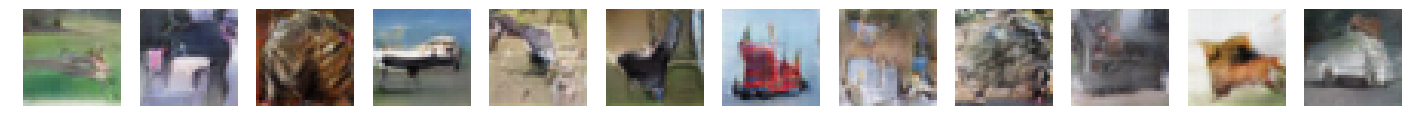

Epoch: 33/65 | Gen. Loss: 0.27764 | Disc. Loss: 0.22535 | Incep. Score: 6.34016
Epoch: 34/65 | Gen. Loss: 0.40494 | Disc. Loss: 0.13551 | Incep. Score: 6.37204
Epoch: 35/65 | Gen. Loss: 0.43458 | Disc. Loss: 0.11895 | Incep. Score: 6.63608


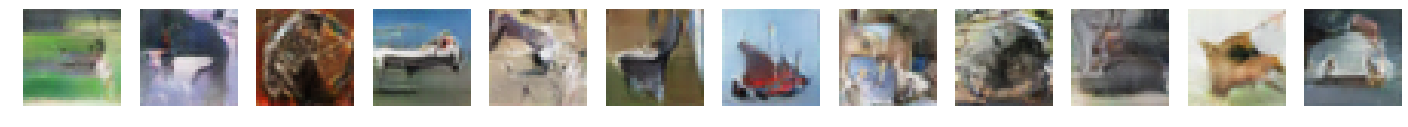

Epoch: 36/65 | Gen. Loss: 0.43508 | Disc. Loss: 0.12109 | Incep. Score: 6.57441
Epoch: 37/65 | Gen. Loss: 0.44366 | Disc. Loss: 0.11473 | Incep. Score: 6.42210
Epoch: 38/65 | Gen. Loss: 0.33924 | Disc. Loss: 0.18165 | Incep. Score: 6.68847


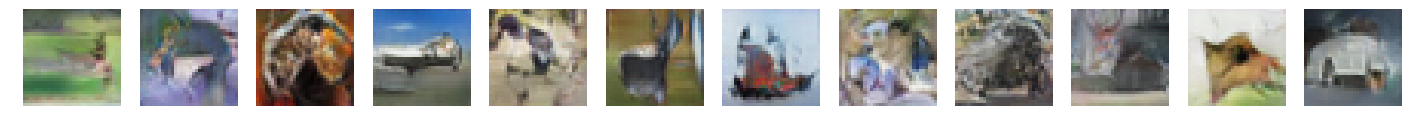

Epoch: 39/65 | Gen. Loss: 0.41171 | Disc. Loss: 0.15147 | Incep. Score: 6.55187
Epoch: 40/65 | Gen. Loss: 0.20376 | Disc. Loss: 0.23623 | Incep. Score: 6.52329
Epoch: 41/65 | Gen. Loss: 0.42640 | Disc. Loss: 0.12571 | Incep. Score: 6.64163
Epoch: 42/65 | Gen. Loss: 0.44611 | Disc. Loss: 0.10633 | Incep. Score: 6.58954
Epoch: 43/65 | Gen. Loss: 0.45077 | Disc. Loss: 0.10577 | Incep. Score: 6.60978
Epoch: 44/65 | Gen. Loss: 0.45649 | Disc. Loss: 0.09956 | Incep. Score: 6.75394


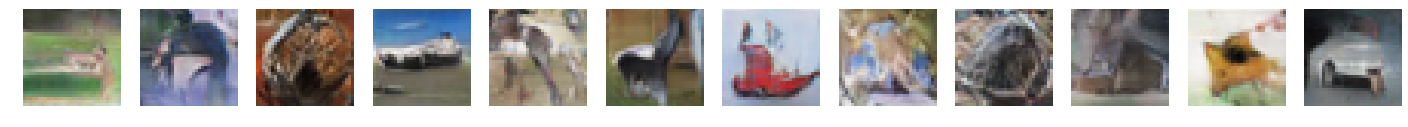

Epoch: 45/65 | Gen. Loss: 0.42104 | Disc. Loss: 0.13293 | Incep. Score: 6.45353
Epoch: 46/65 | Gen. Loss: 0.45340 | Disc. Loss: 0.09280 | Incep. Score: 6.48406
Epoch: 47/65 | Gen. Loss: 0.41002 | Disc. Loss: 0.13879 | Incep. Score: 6.68837
Epoch: 48/65 | Gen. Loss: 0.41883 | Disc. Loss: 0.10994 | Incep. Score: 6.66822
Epoch: 49/65 | Gen. Loss: 0.21549 | Disc. Loss: 0.25858 | Incep. Score: 6.73556
Epoch: 50/65 | Gen. Loss: 0.42092 | Disc. Loss: 0.11640 | Incep. Score: 6.77840


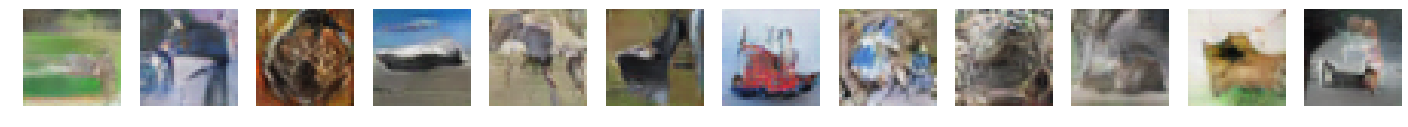

Epoch: 51/65 | Gen. Loss: 0.46492 | Disc. Loss: 0.11990 | Incep. Score: 6.68806
Epoch: 52/65 | Gen. Loss: 0.30528 | Disc. Loss: 0.16935 | Incep. Score: 6.61788
Epoch: 53/65 | Gen. Loss: 0.45755 | Disc. Loss: 0.08649 | Incep. Score: 6.69305
Epoch: 54/65 | Gen. Loss: 0.46280 | Disc. Loss: 0.08627 | Incep. Score: 6.76725
Epoch: 55/65 | Gen. Loss: 0.47094 | Disc. Loss: 0.08358 | Incep. Score: 6.54817
Epoch: 56/65 | Gen. Loss: 0.47428 | Disc. Loss: 0.07970 | Incep. Score: 6.80132


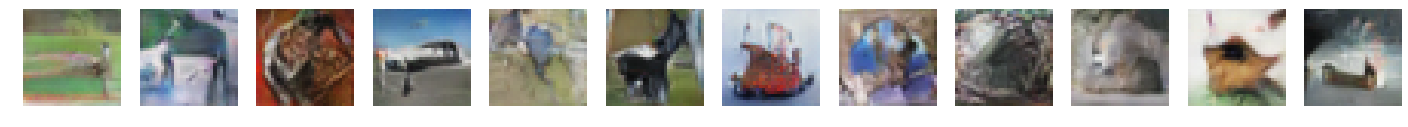

Epoch: 57/65 | Gen. Loss: 0.47467 | Disc. Loss: 0.07927 | Incep. Score: 6.71609
Epoch: 58/65 | Gen. Loss: 0.46774 | Disc. Loss: 0.12114 | Incep. Score: 6.61020
Epoch: 59/65 | Gen. Loss: 0.17597 | Disc. Loss: 0.24433 | Incep. Score: 6.74807
Epoch: 60/65 | Gen. Loss: 0.45013 | Disc. Loss: 0.09944 | Incep. Score: 6.81571


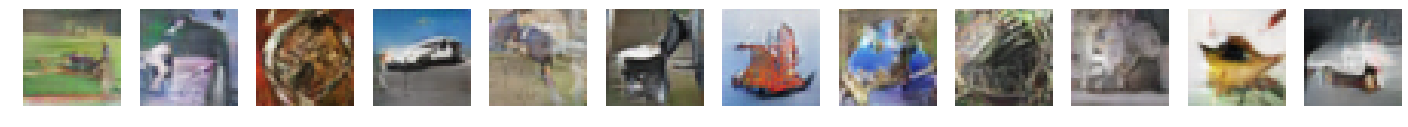

Epoch: 61/65 | Gen. Loss: 0.47032 | Disc. Loss: 0.07962 | Incep. Score: 6.67199
Epoch: 62/65 | Gen. Loss: 0.47814 | Disc. Loss: 0.07535 | Incep. Score: 6.57648
Epoch: 63/65 | Gen. Loss: 0.47843 | Disc. Loss: 0.06873 | Incep. Score: 6.66238
Epoch: 64/65 | Gen. Loss: 0.47707 | Disc. Loss: 0.07660 | Incep. Score: 6.79201
Epoch: 65/65 | Gen. Loss: 0.40745 | Disc. Loss: 0.13370 | Incep. Score: 6.80176


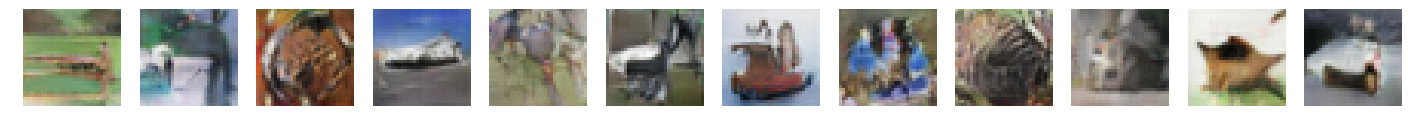

In [0]:
EPOCHS = 65 # 65 * 50000 // 64 ~ 60k iterations
SAMPLES = 12

torch.manual_seed(SEED)
zf = torch.randn(SAMPLES, LATENT_DIM, 1, 1).to(device) # fixed noise for sampling

best_score = 0.0

lossesG = []
lossesD = []
scores = []
for e in range(1, EPOCHS + 1):
    lossesG.append(0)
    lossesD.append(0)
    
    for x, _ in dataloader:
        x = x.to(device)
        z = torch.randn(x.shape[0], LATENT_DIM, 1, 1).to(device)
        Gz = netG(z)
        
        real_labels = torch.ones(x.shape[0], 1).to(device)
        fake_labels = torch.zeros(x.shape[0], 1).to(device)
        
        #----------------Train discriminator: maximize log(D(x)) + log(1 - D(G(z)))----------------#
        real_loss = torch.mean((netD(x) - real_labels)**2)
        fake_loss = torch.mean((netD(Gz.detach()) - fake_labels)**2) # no need to backprop through G
        
        lossD = 0.5*(real_loss + fake_loss); lossesD[-1] += lossD.item()
        optD.zero_grad()
        lossD.backward()
        optD.step()

        #-------------------Train generator: maximize log(D(G(z)))-------------------#
        lossG = 0.5*torch.mean((netD(Gz) - real_labels)**2); lossesG[-1] += lossG.item()
        optG.zero_grad()
        lossG.backward()
        optG.step()

    #-------------------Save losses-------------------#
    lossesG[-1] /= len(dataloader)
    lossesD[-1] /= len(dataloader)
    
    #-------------------Inception score-------------------#
    gen_imgs = []
    for i in range(50):
        z = torch.randn(1000, LATENT_DIM, 1, 1).to(device)
        with torch.no_grad():
            Gz = netG(z)
        imgs = Gz.data.cpu().permute(0, 2, 3, 1).numpy()
        imgs = imgs*127.5 + 127.5 # [-1, 1] --denorm--> [0, 1] --mul by 255--> [0, 255]
        gen_imgs.append(imgs)

    gen_imgs = list(np.concatenate(gen_imgs))
    score = get_inception_score(gen_imgs, batch_size=64, splits=10)
    scores.append(score)
    
    #------------------------Logging------------------------#
    print(f"Epoch: {e:02}/{EPOCHS} "
          f"| Gen. Loss: {lossesG[-1]:.5f} "
          f"| Disc. Loss: {lossesD[-1]:.5f} "
          f"| Incep. Score: {score[0]:.5f}", file=sys.stderr)
    
    if e == EPOCHS or best_score < score[0]:
        best_score = score[0]
        
        #---------------------Saving gen & disc---------------------#
        filepath = f'models/notebook34/netG-{e:02}-{lossesG[-1]:.3f}-{score[0]:.3f}.pt'
        torch.save(netG.state_dict(), filepath)
        filepath = f'models/notebook34/netD-{e:02}-{lossesD[-1]:.3f}.pt'
        torch.save(netD.state_dict(), filepath)
        
        #-------------------Sampling the generator-------------------#
        with torch.no_grad():
            Gz = netG(zf)

        fig, ax = plt.subplots(figsize=(22, 20), nrows=1, ncols=SAMPLES)
        for i in range(SAMPLES):
            img = denorm(Gz[i].data.cpu().permute(1, 2, 0))
            ax[i].imshow(img)
            ax[i].axis('off')
        plt.show()

# 5 min/epoch ~ 5.5 hrs

In [0]:
lossesG, lossesD, scores = map(np.array, (lossesG, lossesD, scores))
np.savez('models/notebook34/stats-cifar.npz', lossesG=lossesG, lossesD=lossesD, scores=scores)

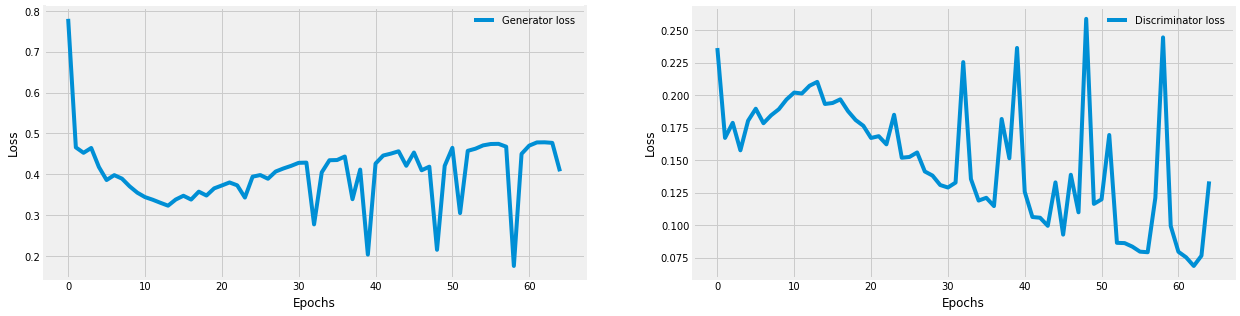

In [0]:
fig = plt.figure(figsize=(19, 5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(lossesG, label='Generator loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

ax = fig.add_subplot(1, 2, 2)
ax.plot(lossesD, label='Discriminator loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

plt.show()

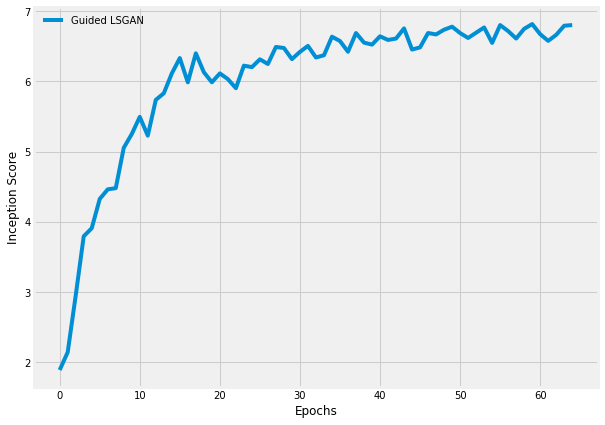

In [0]:
plt.figure(figsize=(9, 7))
plt.plot([mu for mu, std in scores], label='Guided LSGAN')
plt.xlabel('Epochs')
plt.ylabel('Inception Score')
plt.legend(frameon=False)